# R-Learner Estimation with Tabular and Image-based Data

In this code, first I break the data into 16*16 scenes grid and create tabular dataset.
Then, use R-Learner to estimate ATE for this.
Then, I use pre-trained CNN and it to R-Learner to estimate ATE again.
Then, I compare the results.

*Date: June 3rd, 2025*

In [11]:
# Importing Libraries
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

## Tabular Estimation

### Creating Tabular Data

In [5]:
# Loading the dataset
with open("logwet_synth.pkl", "rb") as f:
    treatment = pickle.load(f)

with open("Y_obs_3043.pkl", "rb") as f:
    outcome = pickle.load(f)

with open("cap_3043.pkl", "rb") as f:
    capital = pickle.load(f)

with open("dem_3043.pkl", "rb") as f:
    dem = pickle.load(f)

# Confirm shapes
assert treatment.shape == (256, 256)
assert outcome.shape == (256, 256)
assert capital.shape == (256, 256)
assert dem.shape == (256, 256)



In [ ]:
# Making a Tabular Dataset
BLOCK = 16
n_blocks = 256 // BLOCK   # =16

records = []
scene_id = 0

# 
for i_block in range(n_blocks):
    for j_block in range(n_blocks):
        i0, i1 = i_block * BLOCK, (i_block + 1) * BLOCK
        j0, j1 = j_block * BLOCK, (j_block + 1) * BLOCK

        # Extract 16×16 patches
        T_patch   = treatment[i0:i1, j0:j1]
        Y_patch   = outcome[i0:i1, j0:j1]
        cap_patch = capital[i0:i1, j0:j1]
        dem_patch = dem[i0:i1, j0:j1]

        # Compute averages
        T_avg      = np.nanmean(T_patch)
        Y_avg      = np.nanmean(Y_patch)
        DEM_avg    = np.nanmean(dem_patch)
        cap_log    = np.log1p(cap_patch)
        CapLog_avg = np.nanmean(cap_log)

        records.append({
            "scene_block_id": scene_id,
            "T_avg": T_avg,
            "DEM_avg": DEM_avg,
            "CapLog_avg": CapLog_avg,
            "Y_avg": Y_avg,
            # We’ll also store the flattened patches for PCA later
            "dem_patch_flat": dem_patch.ravel(),
            "caplog_patch_flat": cap_log.ravel(),
            "T_patch_flat": T_patch.ravel(),
            "Y_patch_flat": Y_patch.ravel(),
        })
        scene_id += 1

# Build DataFrame
df_blocks = pd.DataFrame(records)
print("Block‐level tabular dataset (first 5 rows):")
print(df_blocks[["scene_block_id","T_avg","DEM_avg","CapLog_avg","Y_avg"]].head(), "\n")
print("Total blocks:", df_blocks.shape[0])  # should be 256

# df_blocks.to_csv("block_level_data.csv", index=False)


Block‐level tabular dataset (first 5 rows):
   scene_block_id     T_avg   DEM_avg  CapLog_avg      Y_avg
0               0  0.117934  4.216939         0.0  12.147786
1               1  0.114465  3.691374         0.0  11.997122
2               2  0.116991  3.952065         0.0  12.061475
3               3  0.116513  4.000256         0.0  12.081665
4               4  0.117165  4.080194         0.0  12.136448 

Total blocks: 256


### Causal Forest DML


Tabular Causal Forest ATE ≈ 23.3707


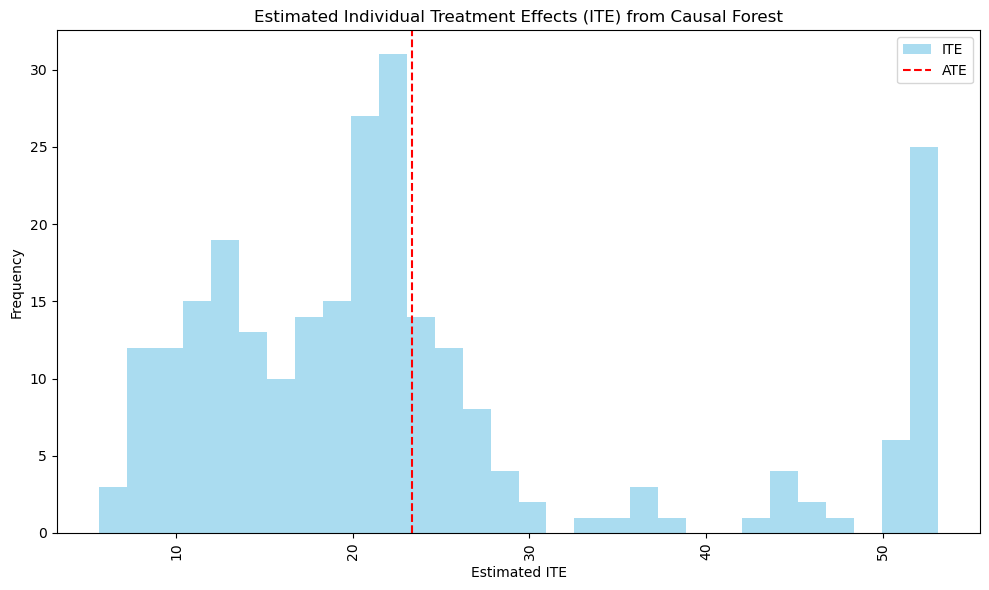

In [20]:
# Prepare the data for Causal Forest
X_tab = df_blocks[["DEM_avg", "CapLog_avg"]].values   # shape (256,2)
T_tab = df_blocks["T_avg"].values                     # shape (256,)
Y_tab = df_blocks["Y_avg"].values                     # shape (256,)

# Model Selection
model_treat   = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
model_outcome = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))

# Fit Causal Forest on tabular data
cf_tab = CausalForestDML(
    model_y = model_outcome,
    model_t = model_treat,
    n_estimators = 100,
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 123
)

cf_tab.fit(Y_tab, T_tab, X=X_tab, W=None)

# Estimate ITE for each block and average to get ATE
ite_tab = cf_tab.effect(X_tab)    # shape (256,)
ate_tab = np.mean(ite_tab)
print(f"Tabular Causal Forest ATE ≈ {ate_tab:.4f}")

# Visualize the estimated ITEs
plt.figure(figsize=(10, 6))
plt.hist(ite_tab, bins=30, color='skyblue', alpha=0.7, label='ITE')
plt.axvline(ate_tab, color='red', linestyle='--', label='ATE')
plt.title('Estimated Individual Treatment Effects (ITE) from Causal Forest')
plt.xlabel('Estimated ITE')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


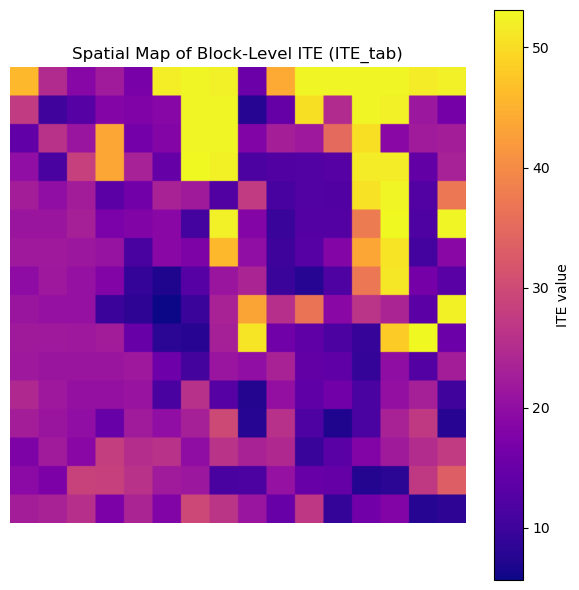

In [18]:
# After computing ite_tab (shape (256,)):
df_blocks['ITE_tab'] = ite_tab

# Now df_blocks has the ITE_tab column and you can plot as before:
df_blocks_sorted = df_blocks.sort_values("scene_block_id")
ids = df_blocks_sorted["scene_block_id"].values
ite_vals = df_blocks_sorted["ITE_tab"].values
BLOCK = 16
n_blocks = 256 // BLOCK   # =16

# Create an empty 256×256 array for the spatial ITE map
ITE_tab_spatial = np.zeros((256, 256), dtype=float)

# Fill each 16×16 block with its corresponding ITE_tab value
for idx, row in df_blocks.iterrows():
    bid = int(df_blocks_sorted["scene_block_id"].values[idx])
    ite_val = df_blocks_sorted["ITE_tab"].values[idx]

    i_block = bid // n_blocks
    j_block = bid % n_blocks
    
    i0, i1 = i_block * BLOCK, (i_block + 1) * BLOCK
    j0, j1 = j_block * BLOCK, (j_block + 1) * BLOCK
    
    ITE_tab_spatial[i0:i1, j0:j1] = ite_val

# Plot the reconstructed ITE map
plt.figure(figsize=(6, 6))
im = plt.imshow(ITE_tab_spatial, cmap='plasma')
plt.title("Spatial Map of Block‐Level ITE (ITE_tab)")
plt.axis('off')
plt.colorbar(im, label="ITE value")
plt.tight_layout()
plt.show()

## Pixel Level Tabular Based Estimation

Pixel-level Causal Forest ATE ≈ -0.0289


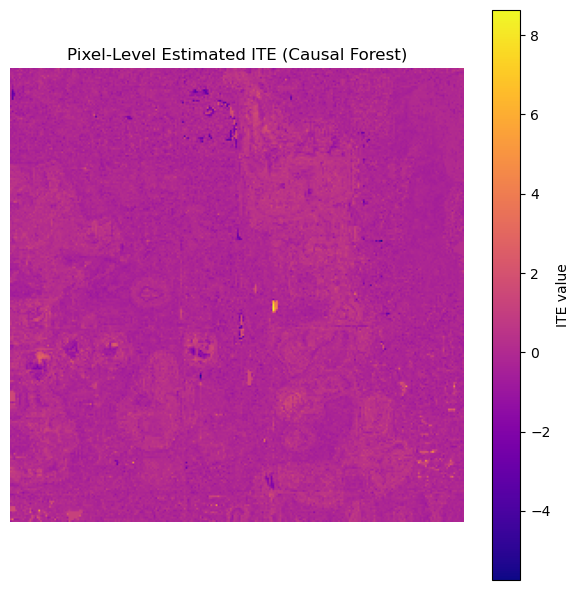

In [ ]:
# Flatten everything to vectors of length N = 256*256
N = 256 * 256
T_px = treatment.ravel()           # (65536,)
Y_px = outcome.ravel()             # (65536,)
DEM_px = dem.ravel()               # (65536,)
Cap_px = capital.ravel()           # (65536,)

# Build the pixel-level covariate matrix X_px = [DEM_px, log(1+Cap_px)]
CapLog_px = np.log1p(Cap_px)
X_px = np.column_stack([DEM_px, CapLog_px])  # shape = (65536, 2)

# Define nuisance models for CausalForestDML
model_treatment = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123)
)
model_outcome = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123)
)

# 4. Instantiate and fit CausalForestDML on pixel-level data
cf_pixel = CausalForestDML(
    model_y=model_outcome,
    model_t=model_treatment,
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=10,
    random_state=123
)
cf_pixel.fit(Y_px, T_px, X=X_px, W=None)

# 5. Estimate pixel-level ITEs (shape = 65536,)
ite_px = cf_pixel.effect(X_px)

# Compute pixel-level ATE
ate_px = np.mean(ite_px)
print(f"Pixel-level Causal Forest ATE ≈ {ate_px:.4f}")

# Reshape ITE back to 256×256 and plot
ITE_px_spatial = ite_px.reshape(256, 256)

plt.figure(figsize=(6, 6))
im = plt.imshow(ITE_px_spatial, cmap='plasma')
plt.title("Pixel‐Level Estimated ITE (Causal Forest)")
plt.axis('off')
plt.colorbar(im, label="ITE value")
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Frequency')

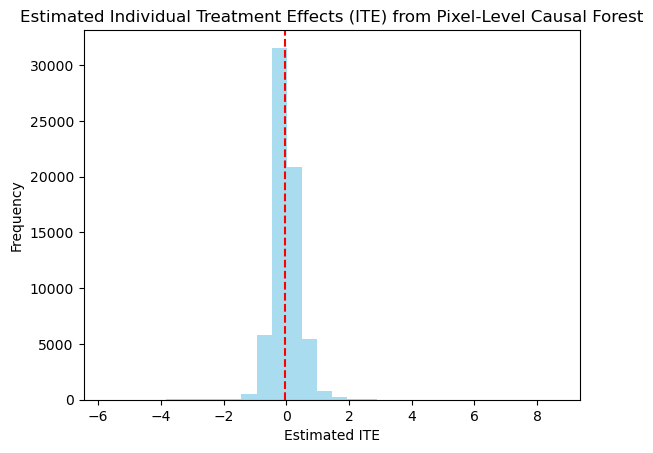

In [24]:
plt.hist(ite_px, bins=30, color='skyblue', alpha=0.7, label='ITE')
plt.axvline(ate_px, color='red', linestyle='--', label='ATE')
plt.title('Estimated Individual Treatment Effects (ITE) from Pixel-Level Causal Forest')
plt.xlabel('Estimated ITE')
plt.ylabel('Frequency')    

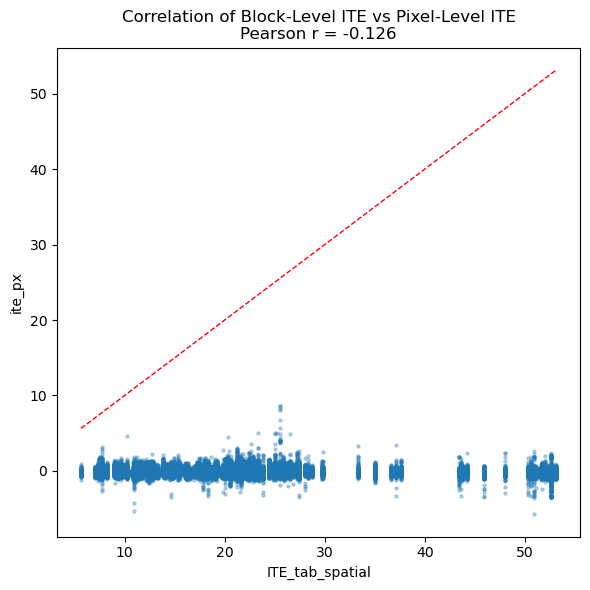

In [26]:
# Flatten both arrays
tab_vals = ITE_tab_spatial.ravel()
px_vals = ite_px.ravel()

# Mask any potential NaNs
mask = (~np.isnan(tab_vals)) & (~np.isnan(px_vals))
tab_vals = tab_vals[mask]
px_vals = px_vals[mask]

# Compute Pearson correlation
corr_coeff = np.corrcoef(tab_vals, px_vals)[0, 1]

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(tab_vals, px_vals, alpha=0.3, s=5)
plt.plot([tab_vals.min(), tab_vals.max()], [tab_vals.min(), tab_vals.max()], 'r--', linewidth=1)
plt.title(f"Correlation of Block‐Level ITE vs Pixel‐Level ITE\nPearson r = {corr_coeff:.3f}")
plt.xlabel("ITE_tab_spatial")
plt.ylabel("ite_px")
plt.tight_layout()
plt.show()